In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import shutil

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc

In [3]:
def load_images_from_folder(folder_path):
    image_data = []  # List to store image data
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            img = cv2.imread(image_path)  # Read the image using OpenCV
            
            if img is not None:
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                variance = cv2.Laplacian(gray, cv2.CV_64F).var()
                
                image_info = {
                    'name': filename,  # Store the image filename
                    'image': img,      # Store the loaded image
                    'variance': variance  # Store the calculated variance
                }
                
                image_data.append(image_info)
    return image_data

In [4]:
folder_path = "Downloads/archive (10)/motion_blurred"
images = load_images_from_folder(folder_path)

In [5]:
categories = "blur"  # You can populate this list based on your image categories
variances = [image_info['variance'] for image_info in images]
image_names = [image_info['name'] for image_info in images]

# Create a dictionary for the DataFrame
data = {
    'Category': categories,
    'Variance': variances,
    'Image_Name': image_names
}

In [6]:
df_motion = pd.DataFrame(data)

In [7]:
folder_path = "Downloads/archive (10)/sharp"
images = load_images_from_folder(folder_path)

In [8]:
categories = "sharp"  # You can populate this list based on your image categories
variances = [image_info['variance'] for image_info in images]
variances = [image_info['variance'] for image_info in images]

# Create a dictionary for the DataFrame
data = {
    'Category': categories,
    'Variance': variances,
    'Image_Name': image_names
}

In [9]:
df_sharp = pd.DataFrame(data)

In [10]:
folder_path = "Downloads/archive (10)/defocused_blurred"
images = load_images_from_folder(folder_path)

In [11]:
categories = "blur"  # You can populate this list based on your image categories
variances = [image_info['variance'] for image_info in images]
variances = [image_info['variance'] for image_info in images]

# Create a dictionary for the DataFrame
data = {
    'Category': categories,
    'Variance': variances,
    'Image_Name': image_names
}

In [12]:
df_defocussed = pd.DataFrame(data)

In [13]:
percentiles = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

result_data = []

# Calculate percentiles for each DataFrame and populate the result DataFrame
for percentile in percentiles:
    variance_value = np.percentile(df_defocussed["Variance"], percentile * 100)
    sharpness_value = np.percentile(df_sharp["Variance"], percentile * 100)
    motion_value = np.percentile(df_motion["Variance"], percentile * 100)
    
    result_data.append({
        "Percentile Range": f"{percentile*100}th",
        "df_motion": motion_value,
        "df_defocussed": variance_value,
        "df_sharp": sharpness_value
    })

result_df = pd.DataFrame(result_data)
print(result_df)

   Percentile Range   df_motion  df_defocussed     df_sharp
0             5.0th   11.482836       6.009269    52.453192
1            10.0th   17.294167       9.416464    71.949404
2            20.0th   26.593368      16.344266   115.704969
3            30.0th   33.785206      21.135657   156.027246
4            40.0th   49.559023      26.759629   218.136581
5            50.0th   63.445699      32.139226   261.506980
6            60.0th   82.857104      44.365028   339.417123
7            70.0th  106.146725      60.860307   507.372591
8            80.0th  147.395191      95.664365   651.677632
9            90.0th  275.299966     162.784000  1078.007183
10           95.0th  497.209569     238.494148  1560.368250


In [14]:
combined_df = pd.concat([df_motion, df_defocussed,df_sharp], ignore_index=True)

print(combined_df)

    Category    Variance               Image_Name
0       blur   64.365429     103_HUAWEI-P20_M.jpg
1       blur   78.370947      104_IPHONE-SE_M.jpg
2       blur   42.468335      105_IPHONE-SE_M.jpg
3       blur  314.721705  107_XIAOMI-MI8-SE_M.jpg
4       blur  417.325428  108_XIAOMI-MI8-SE_M.jpg
..       ...         ...                      ...
733    sharp  194.254659        96_HONOR-7X_M.jpg
734    sharp  139.252947        97_HONOR-7X_M.jpg
735    sharp  213.178318        98_HONOR-7X_M.jpg
736    sharp  651.677632        99_HONOR-7X_M.jpg
737    sharp  225.555985       9_HUAWEI-P20_M.jpg

[738 rows x 3 columns]


In [15]:
# Convert categorical feature to numerical using one-hot encoding
df_encoded = pd.get_dummies(combined_df, columns=['Category'], drop_first=True)

In [16]:
# Split data into features and target
X = df_encoded.drop(columns=['Category_sharp'])  # Dropping one category to avoid multicollinearity
y = df_encoded['Category_sharp']

In [17]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
X_train_temp = X_train.pop('Variance')

In [19]:
X_train.head()

,Image_Name
260,120_HONOR-7X_M.jpg
430,349_IPHONE-SE_M.jpg
135,29_HONOR-7X_M.jpg
360,257_HONOR-9_M.jpg
28,162_IPHONE-6S_M.jpg


In [20]:
X_train_temp.head()

260    16.580920
430    74.514449
135    61.769921
360    43.468719
28     23.782297
Name: Variance, dtype: float64

In [21]:
X_test.head()

,Variance,Image_Name
290,77.638942,180_HONOR-10_M.jpg
331,251.965300,224_ONEPLUS-3T_M.jpg
227,125.461831,80_HUAWEI-P30-PRO_M.jpg
528,110.733517,172_IPHONE-SE_M.jpg
158,59.141931,324_ASUS-ZENFONE-LIVE-ZB501KL_M.jpg


In [22]:
X_test_temp= X_test.pop('Image_Name')

In [23]:
X_test_Variance = X_test.pop('Variance')

In [24]:
X_test.head()

""
290
331
227
528
158


In [25]:
X_test_temp.head()

290                     180_HONOR-10_M.jpg
331                   224_ONEPLUS-3T_M.jpg
227                80_HUAWEI-P30-PRO_M.jpg
528                    172_IPHONE-SE_M.jpg
158    324_ASUS-ZENFONE-LIVE-ZB501KL_M.jpg
Name: Image_Name, dtype: object

In [26]:
y_train.head()

260    False
430    False
135    False
360    False
28     False
Name: Category_sharp, dtype: bool

In [27]:
y_train.value_counts()

Category_sharp
False    392
True     198
Name: count, dtype: int64

In [28]:
y_test.head()

290    False
331    False
227    False
528     True
158    False
Name: Category_sharp, dtype: bool

In [29]:
# Convert data into DMatrix format
dtrain = xgb.DMatrix(X_train_temp, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [30]:
print(dtrain)

In [31]:
# Define hyperparameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,
    'eta': 0.1,
    'gamma': 0,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bytree': 1,
}

In [32]:
# Train the XGBoost model
num_round = 50
model = xgb.train(params, dtrain, num_round)

In [33]:
# Make predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

In [34]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_binary))

Confusion Matrix:
[[100   0]
 [ 48   0]]


In [35]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.68


In [36]:
# Get predicted probabilities on the test set
y_pred_prob = model.predict(dtest)

In [37]:
# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

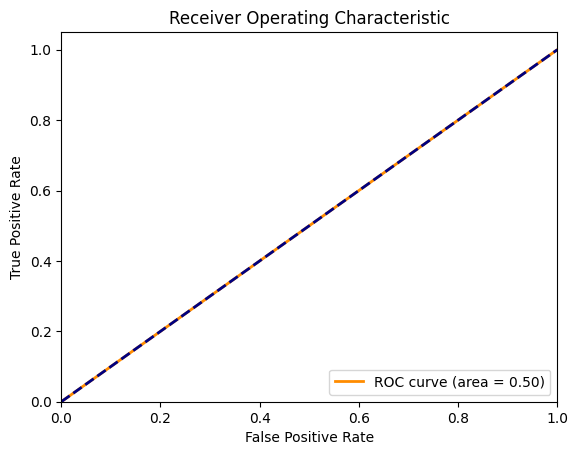

In [38]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [42]:
data_ytest = pd.Series(y_test)

# Convert False to 0 and True to 1
converted_series = data_ytest.astype(int)

In [43]:
data_final = {
    'Variance' : X_test_Variance,
    'Img_name': X_test_temp,
    'Actual': converted_series,
    'Predicted': y_pred_binary
}


In [52]:
df_final = pd.DataFrame(data_final)

In [53]:
print(df_final)

       Variance                             Img_name  Actual  Predicted
290   77.638942                   180_HONOR-10_M.jpg       0          0
331  251.965300                 224_ONEPLUS-3T_M.jpg       0          0
227  125.461831              80_HUAWEI-P30-PRO_M.jpg       0          0
528  110.733517                  172_IPHONE-SE_M.jpg       1          0
158   59.141931  324_ASUS-ZENFONE-LIVE-ZB501KL_M.jpg       0          0
..          ...                                  ...     ...        ...
131   76.530463                  290_IPHONE-SE_M.jpg       0          0
44    74.465175                   180_HONOR-10_M.jpg       0          0
70     3.298292             20_XIAOMI-REDMI-3S_M.jpg       0          0
702   29.915323              61_XIAOMI-REDMI-7_M.jpg       1          0
199  129.711572          4_XIAOMI-PROCOFONE-F1_M.jpg       0          0

[148 rows x 4 columns]


In [ ]:
folders = ['TruePositive', 'TrueNegative', 'FalsePositive', 'FalseNegative']
for folder in folders:
    os.makedirs(folder, exist_ok=True)

In [ ]:
for i, row in df_final.iterrows():
    variance = row['Variance']
    image_name = row['Img_name']
    actual = row['Actual']
    prediction = row['Predicted']

    source_path = f'Downloads/archive (10)/total/{image_name}'  # Replace with actual path
    destination_folder = ''
    
    if not os.path.exists(source_path):
        print(f"Source file '{source_path}' not found. Skipping.")
        continue
        
    if actual == 1 and prediction == 1:
        destination_folder = 'TruePositive'
    elif actual == 0 and prediction == 0:
        destination_folder = 'TrueNegative'
    elif actual == 0 and prediction == 1:
        destination_folder = 'FalsePositive'
    elif actual == 1 and prediction == 0:
        destination_folder = 'FalseNegative'

    destination_path = os.path.join(destination_folder, image_name)
    shutil.move(source_path, destination_path)

In [54]:
folder_path = "TrueNegative"
images = load_images_from_folder(folder_path)

In [55]:
variances = [image_info['variance'] for image_info in images]
image_names = [image_info['name'] for image_info in images]

# Create a dictionary for the DataFrame
data = {
    'Variance': variances,
    'Image_Name': image_names
}

In [56]:
df_tn = pd.DataFrame(data)

In [57]:
print(df_tn)

      Variance                 Image_Name
0    78.370947        104_IPHONE-SE_M.jpg
1    42.468335        105_IPHONE-SE_M.jpg
2   417.325428    108_XIAOMI-MI8-SE_M.jpg
3    54.005647     114_ASUS-ZE500KL_M.jpg
4    35.090080         117_HONOR-7X_M.jpg
..         ...                        ...
65  181.271272     87_IPHONE-8-PLUS_M.jpg
66   18.912714          88_HONOR-8X_M.jpg
67   81.196708  8_SAMSUNG-GALAXY-A6_M.jpg
68   77.092347          90_HONOR-7X_M.jpg
69   33.452966          94_HONOR-7X_M.jpg

[70 rows x 2 columns]


In [58]:
folder_path = "TruePositive"
images = load_images_from_folder(folder_path)

In [59]:
variances = [image_info['variance'] for image_info in images]
image_names = [image_info['name'] for image_info in images]

# Create a dictionary for the DataFrame
data = {
    'Variance': variances,
    'Image_Name': image_names
}

In [60]:
df_tp = pd.DataFrame(data)

In [61]:
print(df_tp)

      Variance                           Image_Name
0   314.721705              107_XIAOMI-MI8-SE_M.jpg
1     6.071561                   120_HONOR-7X_M.jpg
2   568.872230            160_HUAWEI-P20-LITE_M.jpg
3   220.431636              161_XIAOMI-MI8-SE_M.jpg
4   121.475529          165_SAMSUNG-GALAXY-J3_M.jpg
5    34.868285                   178_HONOR-7X_M.jpg
6   159.128169                   185_HONOR-6X_M.jpg
7    53.253431            187_XIAOMI-REDMI-4A_M.jpg
8    44.708475                 252_HUAWEI-P30_M.jpg
9    30.952987             255_XIAOMI-REDMI-7_M.jpg
10  229.437207                   258_HONOR-10_M.jpg
11   11.239133                   261_HONOR-10_M.jpg
12   34.421935            263_XIAOMI-REDMI-3S_M.jpg
13  131.821180      287_WILEYFOX-SWIFT-2-PLUS_M.jpg
14   73.488330          303_SAMSUNG-GALAXY-A8_M.jpg
15   97.637363  312_ASUS-ZENFONE-LIVE-ZB501KL_M.jpg
16   24.736890                   318_HONOR-7C_M.jpg
17  212.829611        340_XIAOMI-PROCOFONE-F1_M.jpg
18   56.3295

In [62]:
folder_path = "FalsePositive"
images = load_images_from_folder(folder_path)

In [63]:
variances = [image_info['variance'] for image_info in images]
image_names = [image_info['name'] for image_info in images]

# Create a dictionary for the DataFrame
data = {
    'Variance': variances,
    'Image_Name': image_names
}

In [64]:
df_fp = pd.DataFrame(data)

In [65]:
print(df_fp)

      Variance                      Image_Name
0   720.835647         164_XIAOMI-MI8-SE_M.jpg
1    51.761279              167_HONOR-7X_M.jpg
2   529.800251       205_HUAWEI-P20-LITE_M.jpg
3   366.131854            224_ONEPLUS-3T_M.jpg
4   580.075347  319_XIAOMI-REDMI-NOTE-4X_M.jpg
5  1297.278765         47_XIAOMI-REDMI-7_M.jpg
6   281.016653     5_XIAOMI-PROCOFONE-F1_M.jpg
7   247.822873               99_HONOR-7X_M.jpg


In [66]:
folder_path = "FalseNegative"
images = load_images_from_folder(folder_path)

In [67]:
variances = [image_info['variance'] for image_info in images]
image_names = [image_info['name'] for image_info in images]

# Create a dictionary for the DataFrame
data = {
    'Variance': variances,
    'Image_Name': image_names
}

In [68]:
df_fn = pd.DataFrame(data)

In [69]:
print(df_fn)

      Variance                     Image_Name
0    82.185092      171_HUAWEI-P20-LITE_M.jpg
1    30.433397            172_IPHONE-SE_M.jpg
2    73.602100                215_LG-Q6_M.jpg
3   123.610430            219_IPHONE-6S_M.jpg
4    21.560796            222_IPHONE-SE_M.jpg
5    50.785747             225_HONOR-7C_M.jpg
6    63.682510            235_IPHONE-SE_M.jpg
7    34.163317    237_SAMSUNG-GALAXY-J5_M.jpg
8    14.466013    309_SAMSUNG-GALAXY-A8_M.jpg
9    48.557227        32_HUAWEI-P-SMART_M.jpg
10  121.177556            338_IPHONE-SE_M.jpg
11   42.379887  343_XIAOMI-PROCOFONE-F1_M.jpg
12   26.593368              86_HONOR-8X_M.jpg
13  114.632356              96_HONOR-7X_M.jpg
14   91.135882              97_HONOR-7X_M.jpg
